In [36]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from pyDOE import lhs
from scipy.stats.distributions import norm

## P-Aminostyrene Synthesis Model

In [37]:
###Helper functions
def activation(x, k, theta, n):
    return (k*x**n)/(theta**n + x**n)
    
def repression(x, k, theta, n):
    return (k*theta**n)/(theta**n + x**n)

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss
    
def name_converter(A):
    name = ''
    for i in range(3):
        arch = A[i]
        if arch == (1, 0, 0, 0, 0):
            name += 'A1'
        elif arch == (0, 1, 0, 0, 0):
            name += 'A2'
        elif arch == (0, 0, 1, 0, 0):
            name += 'R1'
        elif arch == (0, 0, 0, 1, 0):
            name += 'R2'
        elif arch == (0, 0, 0, 0, 1):
            name += 'N'
        name += '-'
    return name[:-1]

###Model definition
def p_aminostyrene(t, y, ydot, params):
    #Parse input parameters
    chorismate, pa1, pa2, pa3, paf, paca_int, paca_ext, promoter1, papA_mrna, papA_uf, papA, papB_mrna, papB_uf, papB, papC_mrna, papC_uf, papC, deaminase, promoter2, laao_mrna, laao_uf, laao, promoter3, eff_mrna, eff_uf, eff, j1, j2 = y
    architecture, thetas, ks, perturbs = params
    theta_paf_prom1, theta_paf_prom2, theta_paf_prom3 = thetas[0]
    theta_paca_prom1, theta_paca_prom2, theta_paca_prom3 = thetas[1]
    k_paf_papA, k_paf_papB, k_paf_papC, k_paf_prom2, k_paf_prom3 = ks[0]
    k_paca_papA, k_paca_papB, k_paca_papC, k_paca_prom2, k_paca_prom3 = ks[1]
    n = 2 #Fix n based on dimerization

    #Cellular constants
    chorismate_production_rate = 1100. #range [2E2, 2E3]
    deaminase_production_rate =  1E1 #range [1E0, 1E2]
    mrna_degradation_rate = 3E-3 #range [3E-4, 3E-2]
    protein_degradation_rate = 2E-4 #range [2E-5, 2E-3]
    protein_folding_rate = 2E0 #range [2E-1, 2E1] 
    dilution_rate = 5.79E-4
    dna_duplication_rate = 5.78E-4
    avogadro = 6.0221408e+23
    cell_volume = 2.5E-15

    #Toxicity factor
    #Perturbed parameters
    ta = perturbs[0] #range [1E-4, 1E-3]
    tp = perturbs[1] #range [1E1, 1E2]
    #Unperturbed parameters
    ki = 5E-5 #range [1E-5, 1E-4]
    tl = 50 #range [1E1, 1E2]
    toxicity_factor = 1/(1 + (paca_int/(ki/ta) + eff/(ki/tp) + laao/(ki/tl)))
    
    pap_mrnalength = 3400
    eff_mrnalength = 2900
    laao_mrnalength = 1600
    ribosome_elongation = 20
    tsn_init = 2E-1

    #Enzyme kinetic parameters
    enzyme_kcat = 5E0 #range [5E-1, 5E1]
    enzyme_km = 1E-6 #range [1E-7, 1E-5]
    papA_kcat = 0.2975
    papA_km = 0.056
    papB_kcat = 39
    papB_km = 0.38 
    papC_kcat = 20.44
    papC_km = 0.555
    laao_kcat = 1.29
    laao_km = 10.82
    deaminase_kcat = enzyme_kcat
    deaminase_km = enzyme_km
    efflux_rate = 275. #range [5E1, 5E2]

    #Kinetic pathway
    chorismate_biosynthesis = chorismate_production_rate * toxicity_factor
    deaminase_biosynthesis = deaminase_production_rate * toxicity_factor
    papA_catalyzed_biosynthesis = papA_kcat * papA * ((chorismate / avogadro) / cell_volume) / (papA_km + ((chorismate / avogadro) / cell_volume)) * toxicity_factor
    papB_catalyzed_biosynthesis = papB_kcat * ((pa1 / avogadro) / cell_volume) / (papB_km + ((pa1 / avogadro) / cell_volume)) * papB * toxicity_factor
    papC_catalyzed_biosynthesis = papC_kcat * papC * ((pa2 / avogadro) / cell_volume) / (papC_km + ((pa2 / avogadro) / cell_volume)) * toxicity_factor
    deaminase_catalyzed_biosynthesis = deaminase_kcat * deaminase * ((pa3 / avogadro) / cell_volume) / (deaminase_km + ((pa3 / avogadro) / cell_volume)) * toxicity_factor
    laao_catalyzed_biosynthesis = laao_kcat * laao * ((paf / avogadro) / cell_volume) / (laao_km + ((paf / avogadro) / cell_volume)) * toxicity_factor
    paca_external_efflux = eff * ((paca_int / avogadro) / cell_volume) * efflux_rate * toxicity_factor

    papA_mrna_txn = np.sum(architecture[0]*np.array([activation(paf, k_paf_papA, theta_paf_prom1, n), activation(paca_int, k_paca_papA, theta_paca_prom1, n), repression(paf, k_paf_papA, theta_paf_prom1, n), repression(paca_int, k_paca_papA, theta_paca_prom1, n), k_paf_papA]))
    papB_mrna_txn = np.sum(architecture[0]*np.array([activation(paf, k_paf_papB, theta_paf_prom1, n), activation(paca_int, k_paca_papB, theta_paca_prom1, n), repression(paf, k_paf_papB, theta_paf_prom1, n), repression(paca_int, k_paca_papB, theta_paca_prom1, n), k_paf_papB]))
    papC_mrna_txn = np.sum(architecture[0]*np.array([activation(paf, k_paf_papC, theta_paf_prom1, n), activation(paca_int, k_paca_papC, theta_paca_prom1, n), repression(paf, k_paf_papC, theta_paf_prom1, n), repression(paca_int, k_paca_papC, theta_paca_prom1, n), k_paf_papC]))
    laao_mrna_txn = np.sum(architecture[1]*np.array([activation(paf, k_paf_prom2, theta_paf_prom2, n), activation(paca_int, k_paca_prom2, theta_paca_prom2, n), repression(paf, k_paf_prom2, theta_paf_prom2, n), repression(paca_int, k_paca_prom2, theta_paca_prom2, n), k_paf_prom2]))
    eff_mrna_txn = np.sum(architecture[2]*np.array([activation(paf, k_paf_prom3, theta_paf_prom3, n), activation(paca_int, k_paca_prom3, theta_paca_prom3, n), repression(paf, k_paf_prom3, theta_paf_prom3, n), repression(paca_int, k_paca_prom3, theta_paca_prom3, n), k_paf_prom3]))

    papA_translation_rate = ((papA_mrna)/(tsn_init + (pap_mrnalength/ribosome_elongation)))
    papB_translation_rate = ((papB_mrna)/(tsn_init + (pap_mrnalength/ribosome_elongation)))
    papC_translation_rate = ((papC_mrna)/(tsn_init + (pap_mrnalength/ribosome_elongation)))
    laao_translation_rate = ((laao_mrna)/(tsn_init + (laao_mrnalength/ribosome_elongation))) 
    eff_translation_rate = ((eff_mrna)/(tsn_init + (eff_mrnalength/ribosome_elongation))) 

    ydot[0] = chorismate_biosynthesis - papA_catalyzed_biosynthesis - chorismate*dilution_rate #chorismate
    ydot[1] = papA_catalyzed_biosynthesis - papB_catalyzed_biosynthesis - pa1*dilution_rate #pa1
    ydot[2] = papB_catalyzed_biosynthesis - papC_catalyzed_biosynthesis - pa2*dilution_rate #pa2
    ydot[3] = papC_catalyzed_biosynthesis - deaminase_catalyzed_biosynthesis - pa3*dilution_rate #pa3
    ydot[4] = deaminase_catalyzed_biosynthesis -  laao_catalyzed_biosynthesis - paf*dilution_rate - paf*1.40E-5 #range [1.4E-6, 1.4E-4] #paf
    ydot[5] = laao_catalyzed_biosynthesis - paca_external_efflux - paca_int*dilution_rate #paca_int 
    ydot[6] = paca_external_efflux #paca_ext
    ydot[7] = promoter1*dna_duplication_rate - promoter1*dilution_rate #promoter1
    ydot[8] = papA_mrna_txn - papA_mrna * dilution_rate - papA_mrna * mrna_degradation_rate * toxicity_factor #papA_mrna
    ydot[9] = papA_translation_rate * toxicity_factor - papA_uf * protein_folding_rate * toxicity_factor - papA_uf * dilution_rate - papA_uf * protein_degradation_rate  * toxicity_factor #papA_uf 
    ydot[10] = papA_uf * protein_folding_rate * toxicity_factor - papA * dilution_rate - papA*protein_degradation_rate*toxicity_factor  #papA 
    ydot[11] = papB_mrna_txn - papB_mrna * dilution_rate - papB_mrna * mrna_degradation_rate * toxicity_factor #papB_mrna
    ydot[12] = papB_translation_rate * toxicity_factor - papB_uf * protein_folding_rate * toxicity_factor - papB_uf * dilution_rate - papB_uf * protein_degradation_rate  * toxicity_factor #papB_uf
    ydot[13] = papB_uf * protein_folding_rate * toxicity_factor - papB * dilution_rate - papB*protein_degradation_rate*toxicity_factor  #papB
    ydot[14] = papC_mrna_txn - papC_mrna * dilution_rate - papC_mrna * mrna_degradation_rate * toxicity_factor  #papC_mrna
    ydot[15] = papC_translation_rate * toxicity_factor - papC_uf * protein_folding_rate * toxicity_factor - papC_uf * dilution_rate - papC_uf * protein_degradation_rate  * toxicity_factor #papC_uf
    ydot[16] = papC_uf * protein_folding_rate * toxicity_factor - papC * dilution_rate - papC*protein_degradation_rate*toxicity_factor #papC
    ydot[17] = deaminase_biosynthesis - deaminase * dilution_rate #deaminase
    ydot[18] = promoter2*dna_duplication_rate - promoter2*dilution_rate #promoter2
    ydot[19] = laao_mrna_txn - laao_mrna * dilution_rate - laao_mrna * mrna_degradation_rate * toxicity_factor  #laao_mrna
    ydot[20] = laao_translation_rate * toxicity_factor - laao_uf * protein_folding_rate * toxicity_factor - laao_uf * dilution_rate - laao_uf * protein_degradation_rate  * toxicity_factor #laao_uf
    ydot[21] = laao_uf * protein_folding_rate * toxicity_factor - laao * dilution_rate - laao*protein_degradation_rate*toxicity_factor  #laao
    ydot[22] = promoter3*dna_duplication_rate - promoter3*dilution_rate #promoter3
    ydot[23] = eff_mrna_txn - eff_mrna * dilution_rate - eff_mrna * mrna_degradation_rate * toxicity_factor  #eff_mrna
    ydot[24] = eff_translation_rate * toxicity_factor - eff_uf * protein_folding_rate * toxicity_factor - eff_uf * dilution_rate - eff_uf * protein_degradation_rate  * toxicity_factor #eff_uf
    ydot[25] = eff_uf * protein_folding_rate * toxicity_factor - eff * dilution_rate - eff*protein_degradation_rate*toxicity_factor  #eff

    #J1 and J2
    ydot[26] = (chorismate_biosynthesis - paca_external_efflux)**2
    ydot[27] = papA_mrna_txn + papB_mrna_txn + papC_mrna_txn + laao_mrna_txn + eff_mrna_txn

###Define search space
architecture = [hp.choice('prom1', [[0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]), hp.choice('prom2', [[1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]), hp.choice('prom3', [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1]])]
space = (architecture, 
            [[hp.uniform('theta_paf_prom1', 1E-7, 10), hp.uniform('theta_paf_prom2', 1E-7, 10), hp.uniform('theta_paf_prom3', 1E-7, 10)], [hp.uniform('theta_paca_prom1', 1E-7, 10), hp.uniform('theta_paca_prom2', 1E-7, 10), hp.uniform('theta_paca_prom3', 1E-7, 10)]], 
            [[hp.uniform('k_paf_papA', 1E-7, 5), hp.uniform('k_paf_papB', 1E-7, 5), hp.uniform('k_paf_papC', 1E-7, 5), hp.uniform('k_paf_prom2', 1E-7, 5), hp.uniform('k_paf_prom3', 1E-7, 5)], [hp.uniform('k_paca_papA', 1E-7, 5), hp.uniform('k_paca_papB', 1E-7, 5), hp.uniform('k_paca_papC', 1E-7, 5), hp.uniform('k_paca_prom2', 1E-7, 5), hp.uniform('k_paca_prom3', 1E-7, 5)]])

###Objective function
def run_hyperopt(max_iters):
    losses = []
    params = []
    circuits = []

    #Define objective function
    def objective(args):
        architecture, thetas, ks = args
        #Integration conditions
        t = np.linspace(0, 1.73E5, 200) 
        y0 = np.array([0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0., 0., 0.]) 
        extra_options = {'old_api': False, 'user_data': [architecture, thetas, ks, perturbs], 'rtol':1E-4}
        ode_solver = ode('cvode', p_aminostyrene, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-12, alpha2=1E-7)
        losses.append(loss)
        params.append([thetas, ks])
        circuits.append(architecture)
        return loss

    #Run hyperopt call
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    #Create trajectory data frame
    theta_paf_prom1s, theta_paf_prom2s, theta_paf_prom3s, theta_paca_prom1s, theta_paca_prom2s, theta_paca_prom3s = [[], [], [], [], [], []]
    k_paf_papAs, k_paf_papBs, k_paf_papCs, k_paf_prom2s, k_paf_prom3s, k_paca_papAs, k_paca_papBs, k_paca_papCs, k_paca_prom2s, k_paca_prom3s = [[], [], [], [], [], [], [], [], [], []]
    for i in range(len(params)):
        thetas = params[0][0]
        ks = params[0][1]
        theta_paf_prom1, theta_paf_prom2, theta_paf_prom3 = thetas[0]
        theta_paca_prom1, theta_paca_prom2, theta_paca_prom3 = thetas[1]
        k_paf_papA, k_paf_papB, k_paf_papC, k_paf_prom2, k_paf_prom3 = ks[0]
        k_paca_papA, k_paca_papB, k_paca_papC, k_paca_prom2, k_paca_prom3 = ks[1]

        theta_paf_prom1s.append(theta_paf_prom1)
        theta_paf_prom2s.append(theta_paf_prom2)
        theta_paf_prom3s.append(theta_paf_prom3)
        theta_paca_prom1s.append(theta_paca_prom1)
        theta_paca_prom2s.append(theta_paca_prom2)
        theta_paca_prom3s.append(theta_paca_prom3)
        k_paf_papAs.append(k_paf_papA)
        k_paf_papBs.append(k_paf_papB)
        k_paf_papCs.append(k_paf_papC)
        k_paf_prom2s.append(k_paf_prom2)
        k_paf_prom3s.append(k_paf_prom3)
        k_paca_papAs.append(k_paca_papA)
        k_paca_papBs.append(k_paca_papB)
        k_paca_papCs.append(k_paca_papC)
        k_paca_prom2s.append(k_paca_prom2)
        k_paca_prom3s.append(k_paca_prom3)

    landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'theta_paf_prom1':theta_paf_prom1s, 'theta_paf_prom2':theta_paf_prom2s, 'theta_paf_prom3':theta_paf_prom3s,
                'theta_paca_prom1':theta_paca_prom1s, 'theta_paca_prom2':theta_paca_prom2s, 'theta_paca_prom3':theta_paca_prom3,
                'k_paf_papA':k_paf_papAs, 'k_paf_papB':k_paf_papBs, 'k_paf_papC':k_paf_papCs, 'k_paf_prom2':k_paf_prom2s, 'k_paf_prom3':k_paf_prom3s,
                'k_paca_papA':k_paca_papAs, 'k_paca_papB':k_paca_papBs, 'k_paca_papC':k_paca_papCs, 'k_paca_prom2':k_paca_prom2s, 'k_paca_prom3':k_paca_prom3s})

    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss:
            best_loss = landscape.loss[i]
            best_circuit = landscape.circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits
    landscape['perturb1'] = perturbs[0]
    landscape['perturb0'] = perturbs[1]

    landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]
    landscape['Best Circuit'] = [name_converter(landscape.best_loss_circuit[i]) for i in range(len(landscape))]
    landscape = landscape.reset_index()
    
    return landscape, best

In [4]:
###Run sample optimization
max_iters = 1000
landscape, best = run_hyperopt(max_iters)
#landscape.to_csv('sample_run.csv')

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

job exception: name 'perturbs' is not defined



  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]


NameError: name 'perturbs' is not defined

In [1]:
###FIGURE: Sample results
#TUNE ORDER MANUALLY
orders = ['R2-A1-N','N-A1-A1', 'R1-A1-A2', 'R2-R2-A2', 
       'R2-N-N', 'R2-R2-A1', 'R1-A1-N', 'R1-N-N', 'R2-N-A2', 'R1-R2-A1', 'N-N-N', 
       'R2-A1-A1', 'N-N-A1', 'N-R2-N', 'N-A1-N', 'N-R2-A1', 
       'N-R2-A2', 'R1-N-A1', 'R2-A1-A2', 'R1-A1-A1', 'R2-N-A1', 'R1-R2-N', 'R2-R2-N',
       'N-N-A2', 'N-A1-A2', 'R1-N-A2', 'R1-R2-A2']
palette = {}
pal = sns.color_palette('Spectral', len(orders))
for i in range(len(orders)):
    palette[orders[i]] = pal[i]


fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(nrows=2, ncols=5, height_ratios=[1,4 ], width_ratios=[3, 1, 1, 1, 1])

ax = fig.add_subplot(gs[:, 0])
prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape['Best Circuit'][i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color=palette[a], linewidth=3)
ax.set_ylabel('Objective Function Value (log)', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)

ax = fig.add_subplot(gs[1, 1:])
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_yscale('log')
ax.set_ylim([10E-3, 10E-1])
sns.scatterplot(x='index', y='loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette)
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(750, 0, 10E9, linestyles='dashed')
ax.set_ylabel(None)


quarter1 = (landscape.iloc[0:250].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
quarter2 = (landscape.iloc[250:500].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
quarter3 = (landscape.iloc[500:750].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
quarter4 = (landscape.iloc[750:1000].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
colors = list(palette.values())

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter1.loss, colors=[palette[a] for a in quarter1.Circuit.unique().tolist()])

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter2.loss, colors=[palette[a] for a in quarter2.Circuit.unique().tolist()])

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter3.loss, colors=[palette[a] for a in quarter3.Circuit.unique().tolist()])

ax = fig.add_subplot(gs[0, 4])
ax.pie(quarter4.loss, colors=[palette[a] for a in quarter4.Circuit.unique().tolist()])

fig.tight_layout()
fig.savefig('sample_results.png', dpi=300)

NameError: name 'sns' is not defined

In [24]:
###Chemical robustness experiments
global perturbs
max_iters = 1000
total_landscape = pd.DataFrame()
total_perturbs = lhs(2, samples=100)
total_perturbs = total_perturbs*([1E-3 - 1E-4, 1E2 - 1E1]) + [1E-4, 1E1]

for p in total_perturbs:
    perturbs = p
    landscape, best = run_hyperopt(max_iters)
    landscape.to_csv('chemical_robustness.csv', mode='a', header=False)
    total_landscape = pd.concat([total_landscape, landscape])

total_landscape.to_csv('chemical_robustness_backup.csv')

 34%|███▍      | 342/1000 [01:10<01:53,  5.78trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 823.862, mxstep steps taken before reaching tout.



 64%|██████▍   | 638/1000 [02:22<01:17,  4.64trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 852.207, mxstep steps taken before reaching tout.



 19%|█▉        | 189/1000 [00:39<02:04,  6.52trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 595.986, mxstep steps taken before reaching tout.



 48%|████▊     | 480/1000 [02:02<01:47,  4.84trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 799.828, mxstep steps taken before reaching tout.



 78%|███████▊  | 779/1000 [03:30<00:51,  4.33trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 807.633, mxstep steps taken before reaching tout.



 50%|████▉     | 498/1000 [01:54<01:25,  5.85trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 707.252, mxstep steps taken before reaching tout.



 22%|██▏       | 215/1000 [00:44<02:35,  5.04trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 862.684, mxstep steps taken before reaching tout.



 25%|██▌       | 250/1000 [00:51<02:54,  4.31trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 681.338, mxstep steps taken before reaching tout.



  6%|▌         | 61/1000 [00:06<01:08, 13.73trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 848.407, mxstep steps taken before reaching tout.



 27%|██▋       | 268/1000 [01:00<02:40,  4.57trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 819.103, mxstep steps taken before reaching tout.



 40%|███▉      | 399/1000 [01:32<02:40,  3.75trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 765.138, mxstep steps taken before reaching tout.



 31%|███▏      | 314/1000 [01:19<02:47,  4.10trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 800.006, mxstep steps taken before reaching tout.



 28%|██▊       | 277/1000 [01:04<02:47,  4.32trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 710.022, mxstep steps taken before reaching tout.



 46%|████▌     | 462/1000 [01:57<02:12,  4.05trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 716.934, mxstep steps taken before reaching tout.



 33%|███▎      | 331/1000 [01:20<03:02,  3.68trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 763.518, mxstep steps taken before reaching tout.



 36%|███▋      | 363/1000 [01:20<02:00,  5.30trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 759.346, mxstep steps taken before reaching tout.



 16%|█▌        | 162/1000 [00:33<02:07,  6.57trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 749.655, mxstep steps taken before reaching tout.



 57%|█████▊    | 575/1000 [02:15<01:27,  4.84trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 848.779, mxstep steps taken before reaching tout.



 72%|███████▎  | 725/1000 [02:59<01:06,  4.17trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 825.289, mxstep steps taken before reaching tout.



100%|██████████| 1000/1000 [01:41<00:00,  9.82trial/s, best loss: 0.004115020416383817]


In [32]:
#Filter experiment results for ODE errors
total_landscape = pd.read_csv('chemical_robustness_backup.csv').reset_index()
#Recompute best loss on non-error samples
start=0
stop=1000
new_total_landscape = pd.DataFrame()
for j in range(100):
    landscape = total_landscape.iloc[start:stop].reset_index(drop=True)
    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss and landscape.loss[i] != 0:
            best_loss = landscape.loss[i]
            best_circuit = landscape.circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits 
    new_total_landscape = pd.concat([new_total_landscape, landscape])
    start = stop
    stop += 1000
new_total_landscape = new_total_landscape.loc[new_total_landscape.loss != 0]

In [38]:
##Assess background by running 100x
global perturbs
max_iters = 1000
total_background = pd.DataFrame()
perturbs = [1., 1.]
for i in range(100):
    background, best = run_hyperopt(max_iters)
    background.to_csv('background.csv', mode='a', header=False)
    total_background = pd.concat([total_background, background])

total_background.to_csv('background_total.csv')


  5%|▍         | 49/1000 [00:07<02:20,  6.79trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 711.066, mxstep steps taken before reaching tout.



 18%|█▊        | 177/1000 [00:38<02:54,  4.71trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 807.83, mxstep steps taken before reaching tout.



 91%|█████████ | 909/1000 [03:34<00:22,  4.08trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 865.85, mxstep steps taken before reaching tout.



  3%|▎         | 34/1000 [00:06<02:49,  5.71trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 676.72, mxstep steps taken before reaching tout.



  7%|▋         | 69/1000 [00:14<04:34,  3.39trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 693.172, mxstep steps taken before reaching tout.



 31%|███       | 311/1000 [01:08<01:57,  5.86trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 741.723, mxstep steps taken before reaching tout.



  6%|▌         | 60/1000 [00:09<02:18,  6.78trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 846.46, mxstep steps taken before reaching tout.



 11%|█         | 107/1000 [00:20<02:10,  6.86trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 533.076, mxstep steps taken before reaching tout.



 38%|███▊      | 381/1000 [01:22<02:05,  4.92trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 676.173, mxstep steps taken before reaching tout.



 71%|███████   | 710/1000 [02:37<00:59,  4.85trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 813.147, mxstep steps taken before reaching tout.



 16%|█▌        | 157/1000 [00:30<03:13,  4.37trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 830.221, mxstep steps taken before reaching tout.



 26%|██▌       | 258/1000 [00:54<02:21,  5.25trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 762.299, mxstep steps taken before reaching tout.



 33%|███▎      | 329/1000 [01:15<01:47,  6.25trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 754.083, mxstep steps taken before reaching tout.



  6%|▋         | 63/1000 [00:12<03:07,  5.00trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 621.304, mxstep steps taken before reaching tout.



 54%|█████▍    | 543/1000 [02:02<01:33,  4.88trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 844.127, mxstep steps taken before reaching tout.



 16%|█▋        | 164/1000 [00:32<03:20,  4.17trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 828.802, mxstep steps taken before reaching tout.



 31%|███       | 309/1000 [01:07<02:37,  4.39trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 857.886, mxstep steps taken before reaching tout.



 32%|███▏      | 317/1000 [01:02<01:43,  6.59trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 736.301, mxstep steps taken before reaching tout.



  8%|▊         | 79/1000 [00:17<02:49,  5.43trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 778.474, mxstep steps taken before reaching tout.



 96%|█████████▋| 964/1000 [03:56<00:08,  4.34trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 764.659, mxstep steps taken before reaching tout.



  6%|▌         | 59/1000 [00:11<02:11,  7.16trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 834.371, mxstep steps taken before reaching tout.



 77%|███████▋  | 766/1000 [02:59<00:48,  4.79trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 689.304, mxstep steps taken before reaching tout.



  2%|▏         | 23/1000 [00:03<02:05,  7.79trial/s, best loss: 0.058468340371637624]


[CVODE ERROR]  CVode
  At t = 715.057, mxstep steps taken before reaching tout.



 79%|███████▉  | 793/1000 [03:14<00:50,  4.11trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 811.762, mxstep steps taken before reaching tout.



  2%|▏         | 17/1000 [00:02<03:09,  5.18trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 835.364, mxstep steps taken before reaching tout.



 56%|█████▌    | 557/1000 [02:26<01:31,  4.83trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 710.574, mxstep steps taken before reaching tout.



 71%|███████   | 710/1000 [02:49<01:03,  4.55trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 750.863, mxstep steps taken before reaching tout.



 19%|█▊        | 186/1000 [00:40<02:49,  4.82trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 780.016, mxstep steps taken before reaching tout.



 10%|█         | 105/1000 [00:15<02:55,  5.11trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 770.612, mxstep steps taken before reaching tout.



 69%|██████▉   | 688/1000 [02:27<01:03,  4.92trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 786.921, mxstep steps taken before reaching tout.



 55%|█████▌    | 552/1000 [02:03<01:18,  5.72trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 516.712, mxstep steps taken before reaching tout.



 35%|███▌      | 352/1000 [01:13<02:10,  4.98trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 572.305, mxstep steps taken before reaching tout.



 97%|█████████▋| 969/1000 [02:51<00:06,  4.80trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 813.579, mxstep steps taken before reaching tout.



 11%|█         | 107/1000 [00:17<02:25,  6.14trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 838.575, mxstep steps taken before reaching tout.



 68%|██████▊   | 685/1000 [02:22<00:56,  5.60trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 789.429, mxstep steps taken before reaching tout.



100%|██████████| 1000/1000 [02:16<00:00,  7.33trial/s, best loss: 0.0033441793548153725]


/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82071/2048842858.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_landscape['abs_loss_difference'] = np.abs(plot_landscape.best_losses - mean_optimal_loss)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_82071/2048842858.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_landscape['percent_loss_difference'] = 100*(plot_landscape.best_losses - mean_optimal_loss)/mean_optimal_loss


(0.0005, 0.001)

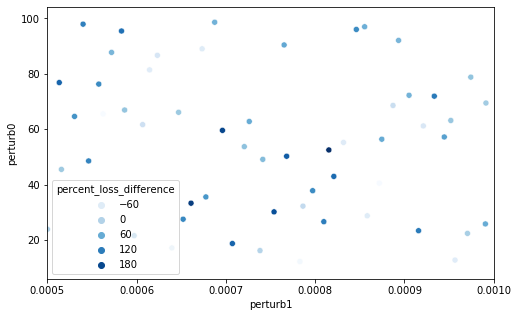

In [159]:
###FIGURE: Chemical robustness
mean_optimal_loss = total_background.loc[total_background.index == 999].best_losses.mean()
plot_landscape = new_total_landscape.loc[new_total_landscape.index==999]
plot_landscape['abs_loss_difference'] = np.abs(plot_landscape.best_losses - mean_optimal_loss)
plot_landscape['percent_loss_difference'] = 100*(plot_landscape.best_losses - mean_optimal_loss)/mean_optimal_loss

fig, ax = plt.subplots(1,1,figsize=(8, 5))
sns.scatterplot(data=plot_landscape, x='perturb1', y='perturb0', hue='percent_loss_difference', ax=ax, palette='Blues')
ax.set_xlim([5E-4, 10E-4])

Text(0.5, 1.0, 'Absolute Percentage Loss Difference')

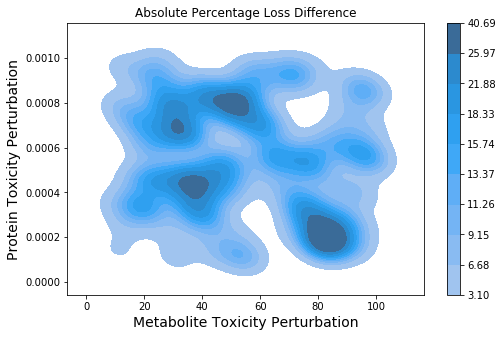

In [158]:
###FIGURE: Chemical robustness
p1 = []; p2 = []
for i in range(len(plot_landscape)):
    loss_percent = int(np.abs(round(plot_landscape.iloc[i].percent_loss_difference, 0)))
    for j in range(loss_percent):
        p1.append(plot_landscape.iloc[i].perturb0)
        p2.append(plot_landscape.iloc[i].perturb1)
plot_data = pd.DataFrame({'perturb0': p1, 'perturb1':p2})

fig, ax = plt.subplots(1,1,figsize=(8, 5))
sns.kdeplot(data=plot_data, x='perturb0', y='perturb1', fill=True, palette='Blues', cbar=True)
ax.set_ylabel('Protein Toxicity Perturbation', fontsize=14)
ax.set_xlabel('Metabolite Toxicity Perturbation', fontsize=14)
ax.set_title('Absolute Percentage Loss Difference')

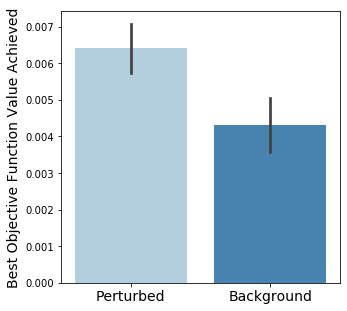

In [129]:
###FIGURE: Chemical robustness
plot_data = pd.DataFrame({'best_loss': plot_landscape.best_losses.to_list(), 'type':'Perturbed'})
plot_data = pd.concat([plot_data, pd.DataFrame({'best_loss':total_background.loc[total_background.index == 999].best_losses.to_list(), 'type':'Background' })])
fig, ax = plt.subplots(1,1,figsize=(5, 5))
sns.barplot(data=plot_data, y='best_loss', x='type', palette='Blues', ax=ax)
ax.set_ylabel('Best Objective Function Value Achieved', fontsize=14)
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize=14)

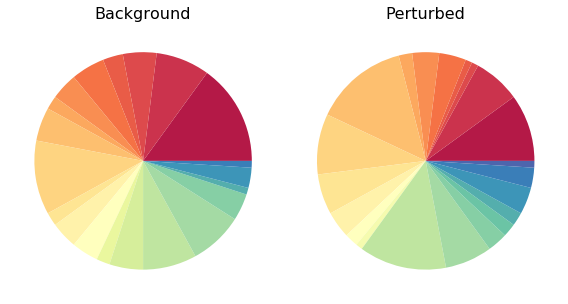

In [114]:
###FIGURE: Chemical robustness
background_pie = (total_background.loc[total_background.index == 999].groupby('Best Circuit').count()['Circuit']/100).reset_index()
perturb_pie = (plot_landscape.groupby('Best Circuit').count()['Circuit']/100).reset_index()

#Palette code from above 
orders = ['N-A1-A1', 'N-A1-A2', 'N-A1-N', 'N-N-A1', 'N-N-A2', 'N-R2-A1',
       'N-R2-A2', 'R1-A1-A1', 'R1-A1-A2', 'R1-A1-N', 'R1-N-A1', 'R1-N-A2', 'R1-R2-N',
       'R1-R2-A1', 'R1-R2-A2', 'R2-A1-A1', 'R2-A1-A2', 'R2-A1-N','R2-N-A1',
       'R2-N-A2', 'R2-R2-A1', 'R2-R2-A2', 'R2-R2-N']
palette = {}
pal = sns.color_palette('Spectral', len(orders))
for i in range(len(orders)):
    palette[orders[i]] = pal[i]

perturb_colors = [palette.get(key) for key in ['N-A1-A1', 'N-A1-A2', 'N-A1-N', 'N-N-A1', 'N-N-A2', 'N-R2-A1',
       'N-R2-A2', 'R1-A1-A1', 'R1-A1-A2', 'R1-A1-N', 'R1-N-A1', 'R1-N-A2',
       'R1-R2-N', 'R2-A1-A1', 'R2-A1-A2', 'R2-A1-N', 'R2-N-A1', 'R2-N-A2',
       'R2-R2-A1', 'R2-R2-A2', 'R2-R2-N']]
       
background_colors = [palette.get(key) for key in ['N-A1-A1', 'N-A1-A2', 'N-A1-N', 'N-N-A1', 'N-N-A2', 'N-R2-A1',
       'N-R2-A2', 'R1-A1-A1', 'R1-A1-A2', 'R1-A1-N', 'R1-N-A1', 'R1-N-A2',
       'R1-R2-A1', 'R1-R2-A2', 'R2-A1-A1', 'R2-A1-A2', 'R2-A1-N',
       'R2-N-A2', 'R2-R2-A1', 'R2-R2-A2']]

fig, axs = plt.subplots(1,2,figsize=(8, 5))
ax = axs[0]
ax.set_title('Background', fontsize=16)
ax.pie(background_pie.Circuit, colors=background_colors);
ax = axs[1]
ax.set_title('Perturbed', fontsize=16)
ax.pie(perturb_pie.Circuit, colors=perturb_colors);
fig.tight_layout()